In [ ]:
# inspired from https://towardsdatascience.com/tile-slice-yolo-dataset-for-small-objects-detection-a75bf26f7fa2
# In this article he does discuss about the tiling that he had used for yolo. Plan  on using that for mobillenet

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!pip install shapely

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt
import glob
from pathlib import Path

### Experimenting

In [7]:
imname = '/Users/krish/ljmu/1.data/afo/tiledv3/train/ts/a_106_0_8'
im = Image.open(fr'{imname}.jpg')
df = pd.read_csv(fr'{imname}.txt', sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
imr = np.array(im, dtype=np.uint8)

In [8]:
df

,class,x1,y1,w,h
0,0,0.99,0.263333,0.013333,0.336667


In [9]:
df_scaled = df.iloc[:, 1:]
df_scaled[['x1', 'w']] = df_scaled[['x1', 'w']] * imr.shape[1]
df_scaled[['y1', 'h']] = df_scaled[['y1', 'h']] * imr.shape[0]

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_50092/3236233940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled[['x1', 'w']] = df_scaled[['x1', 'w']] * imr.shape[1]
/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_50092/3236233940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled[['y1', 'h']] = df_scaled[['y1', 'h']] * imr.shape[0]


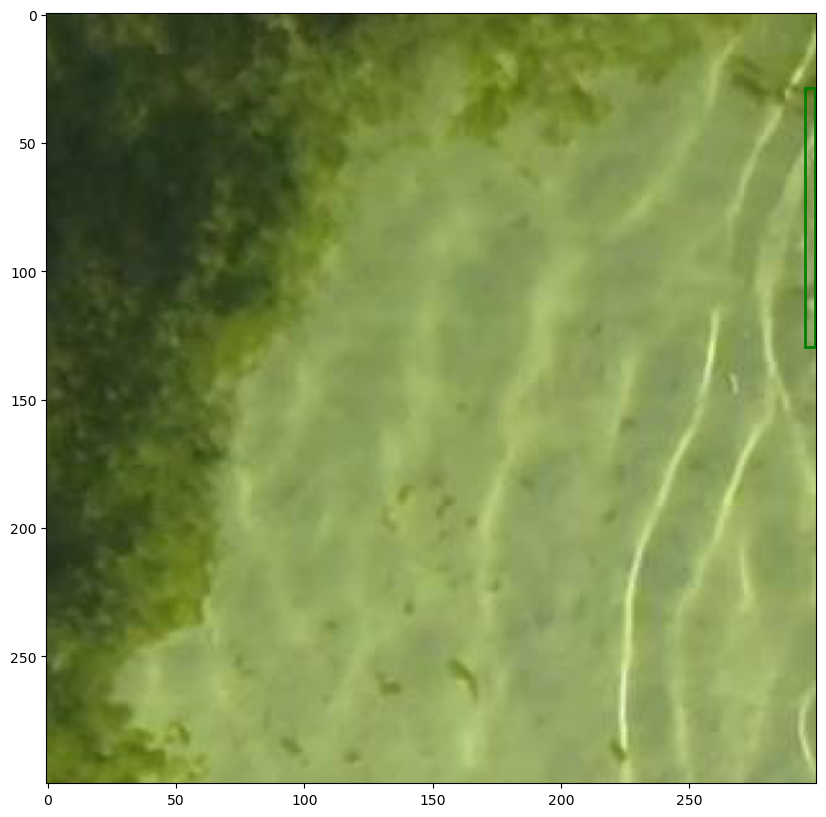

In [10]:
import matplotlib.patches as patches# Create figure and axes
fig,ax = plt.subplots(1, figsize=(10,10))# Display the image
ax.imshow(imr)
for box in df_scaled.values:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0]-(box[2]/2),box[1]-(box[3]/2)),box[2],box[3],linewidth=2,edgecolor='g',facecolor='none')# Add the patch to the axes
    ax.add_patch(rect)
    
plt.show()

In [ ]:
glob.glob('*Jpg')

[]

In [ ]:
# Mac directory
# source_dir = r'/Users/krish/ljmu/1.data/swimmers_dataset/training_dataset/'
# destination_dir = r'/Users/krish/ljmu/1.data/swimmers_dataset/krish_train/'

### Actual implimentation

In [6]:
# get all image names
imnames = glob.glob('/Users/krish/ljmu/1.data/swimmers_dataset/krish_train/*.jpg')
#imnames = glob.glob('/content/drive/MyDrive/ljmu/1.data/swimmers_dataset/krish_train/*.jpg')
# specify path for a new tiled dataset
newpath = '/Users/krish/ljmu/1.data/sampletiled/ts/'
#newpath = '/content/drive/MyDrive/ljmu/1.data/sampletiled/ts'
falsepath = '/Users/krish/ljmu/1.data/sampletiled/false/'
#falsepath = '/content/drive/MyDrive/ljmu/1.data/sampletiled/false'
# python program to check if a path exists
#if path doesn’t exist we create a new path

#creating a new directory called pythondirectory
Path(newpath).mkdir(parents=True, exist_ok=True)
Path(falsepath).mkdir(parents=True, exist_ok=True)

# specify slice width=height
slice_size = 500

# tile all images in a loop

for imname in imnames:
    im = Image.open(imname)
    imr = np.array(im, dtype=np.uint8)
    height = imr.shape[0]
    width = imr.shape[1]
    labname = imname.replace('.jpg', '.txt')
    labels = pd.read_csv(labname, sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
    
    # we need to rescale coordinates from 0-1 to real image height and width
    labels[['x1', 'w']] = labels[['x1', 'w']] * width
    labels[['y1', 'h']] = labels[['y1', 'h']] * height
    
    boxes = []
    #print(labels)
    # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
    for row in labels.iterrows():
        x1 = row[1]['x1'] - row[1]['w']/2
        y1 = (height - row[1]['y1']) - row[1]['h']/2
        x2 = row[1]['x1'] + row[1]['w']/2
        y2 = (height - row[1]['y1']) + row[1]['h']/2

        boxes.append((int(row[1]['class']), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))
    
    counter = 0
    print('Image:', imname)
    # create tiles and find intersection with bounding boxes for each tile
    for i in range((height // slice_size)):
        for j in range((width // slice_size)):
            x1 = j*slice_size
            y1 = height - (i*slice_size)
            x2 = ((j+1)*slice_size) - 1
            y2 = (height - (i+1)*slice_size) + 1

            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            imsaved = False
            slice_labels = []

            for box in boxes:
                if pol.intersects(box[1]):
                    inter = pol.intersection(box[1])        
                    
                    if not imsaved:
                        sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                        sliced_im = Image.fromarray(sliced)
                        filename = imname.split('/')[-1]
                        ##filename = imname
                        slice_path = newpath + filename.replace('.jpg', f'_{i}_{j}.jpg')
                        
                        slice_labels_path = newpath + filename.replace('.jpg', f'_{i}_{j}.txt')
                        
                        print(slice_path)
                        #print('hi')
                        sliced_im.save(slice_path)
                        imsaved = True                    
                    
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get central point for the new bounding box 
                    centre = new_box.centroid
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    # get bounding box width and height normalized to slice size
                    new_width = (max(x) - min(x)) / slice_size
                    new_height = (max(y) - min(y)) / slice_size
                    
                    # we have to normalize central x and invert y for yolo format
                    new_x = (centre.coords.xy[0][0] - x1) / slice_size
                    new_y = (y1 - centre.coords.xy[1][0]) / slice_size
                    
                    counter += 1

                    slice_labels.append([box[0], new_x, new_y, new_width, new_height])
            
            # save txt with labels for the current tile
            if len(slice_labels) > 0:
                slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
                #print(slice_df)
                slice_df.to_csv(slice_labels_path, sep=' ', index=False, header=False, float_format='%.6f')
            
            # if there are no bounding boxes intersect current tile, save this tile to a separate folder 
            if not imsaved:
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                sliced_im = Image.fromarray(sliced)
                filename = imname.split('/')[-1]
                #filename = imname
                slice_path = falsepath + filename.replace('.jpg', f'_{i}_{j}.jpg')                

                sliced_im.save(slice_path)
                print('Slice without boxes saved')
                imsaved = True
    #break

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/63.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/63_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/823.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/823_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/823_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4217.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3578.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3578_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3578_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2666.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2666_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2666_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/11981.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/11981_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_tr

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/360.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/360_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/406.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/406_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1192.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130244.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1186.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1186_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1186_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/412.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/412_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/412_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130250.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4798.jpg
Slice without boxes s

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130640.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1596.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3381.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2921.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/764.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3380.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1597.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130641.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/765.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2920.jpg
Slice withou

/Users/krish/ljmu/1.data/sampletiled/ts/1018_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1018_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4160.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130251.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/413.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/413_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/413_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1187.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1187_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1187_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/375.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130537.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1839.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swim

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/836.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/836_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/836_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/76.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2673.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2673_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2673_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4202.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4202_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4202_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2667.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2667_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2667_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3579.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3579_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3579_0_1.jpg
Ima

/Users/krish/ljmu/1.data/sampletiled/ts/1634_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1807.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1807_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130509.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/8837.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/8837_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/439.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/439_0_0.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/12092.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1813.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130535.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/377.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/377_

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1224_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/983.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/983_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/983_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/997.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/997_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/997_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2922.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/767.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1595.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3382.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3396.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1581.jpg


Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1033.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1033_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1033_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3624.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3624_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3624_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4163.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4605.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/6012.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/6012_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1769.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4611.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimm

/Users/krish/ljmu/1.data/sampletiled/ts/809_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/809_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1345.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1345_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/49.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/49_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1423.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1423_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1423_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3234.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9057.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9057_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4573.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2664.jpg
Slice without boxes saved
/Users/krish/lj

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2338.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1631.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1631_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1631_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130281.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1157.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4761.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1619.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1619_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1619_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/399.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/399_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/399_0_1.jpg
Image: /Use

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1235_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3422.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2728.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2728_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3436.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1221.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1221_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1547.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1547_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3350.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3378.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4417.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4417_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_data

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/561_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/207.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1793.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1793_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1793_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4833.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4600.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1778.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1778_0_0.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4166.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3609.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3594.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3594_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3594_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2661.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2661_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4210.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4210_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/824.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/824_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/824_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/64.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/64_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1368.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1368_0_1.jpg
Image: /Users/krish/ljmu/1.data/s

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2844.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2688.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2688_0_0.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3596.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3596_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3596_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2850.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9905.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/615.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/615_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1381.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1381_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1791.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1791_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1791_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/205.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1949.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/563.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/563_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130309.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10091.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4819.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1961.jpg
Slice without boxes s

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4429.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4429_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3346.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/5723.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/5723_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3352.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1545.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1545_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1223.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1223_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3434.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1974.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/238.jpg
Slice without boxes saved
/Us

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130718.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2879.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1380.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1380_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1380_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/614.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/614_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2851.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3597.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3597_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3597_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2689.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2689_0_0.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swim

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/129.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/129_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1495.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1495_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/101.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/101_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130743.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3282.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2822.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/667.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/667_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/667_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/673.jpg
Slice without boxes saved
Slice without boxes saved

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4843.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/277.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/277_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/263.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2598.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2598_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1091.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1091_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1091_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/505.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/505_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4466.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/kr

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1279.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/935.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/935_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/935_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2770.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/262.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/504.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/504_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1090.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1090_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1090_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2599.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/kri

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/672.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/6489.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/6489_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1480.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1480_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/114.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3297.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3283.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130742.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/100.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/100_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1494.jpg
Slice without boxes saved
/User

Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/894.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/880.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/880_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/880_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/658.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/658_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/658_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3295.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/116.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1482.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1482_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/670.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1723.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1723_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1723_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3652.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1045.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1045_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1910.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/248.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/248_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1904.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1092.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1092_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1534.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130184.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1252.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2983.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3445.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/936.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/936_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/936_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2773.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2773_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10552.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_datase

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/498.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/498_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1118.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1118_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1118_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2411.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2411_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2411_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2377.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3069.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4706.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/665.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/665_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/665_0_1.jpg
Image: /Users/

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2603.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/846.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/846_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/846_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/675.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/675_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2830.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3290.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/113.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1487.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1487_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130745.jpg
Image: /Users/krish/ljmu

/Users/krish/ljmu/1.data/sampletiled/ts/1040_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1726.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1726_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1726_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9352.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9352_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10998.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/10998_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4676.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2561.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2561_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1068.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1068_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1068_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/k

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/700.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/700_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130142.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130624.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4461.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1519.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1519_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/933.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/933_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/933_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3468.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2776.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2762.jpg
Sli

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1109.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1109_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1109_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9233.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2366.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4717.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3078.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2372.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2372_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2372_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4703.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/8887.jpg
/Users/krish/ljmu/1.

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1447.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1447_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1447_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3250.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3536.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4259.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4259_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2628.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1321.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1321_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2600.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2600_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1309.jpg
Slice without boxes saved
/Users/krish/ljmu/1

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1043.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1043_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1043_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1057.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1057_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1057_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3640.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/11307.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/11307_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4649.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1731.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1731_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1731_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/kr

Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3480.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2946.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1297.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1297_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/703.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/703_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130141.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/717.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/717_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/717_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1283.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130155.jpg
Image: /Users/krish/l

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/307.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3084.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/461.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/461_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/461_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130223.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/6671.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/5378.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2417.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2417_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2417_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2371.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2371_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_datase

/Users/krish/ljmu/1.data/sampletiled/ts/861_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4255.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4255_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2624.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4241.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4241_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2630.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2630_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/35.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/35_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1339.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1339_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/875.jpg
/Users/krish/ljm

Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130548.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2397.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2397_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3089.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/444.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/444_0_0.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130206.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130560.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/322.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/322_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130574.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/336.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/336_0_1.jpg


Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4484.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4484_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4484_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2793.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130158.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3499.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2787.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4490.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130616.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/732.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130170.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/kr

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1700.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1700_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1700_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/12159.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10996.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4678.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3117.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1728.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1728_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1728_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4650.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3659.jpg
/Users/krish/ljmu/

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2619_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3507.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/874.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/874_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/874_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1338.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1338_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/34.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/34_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2631.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2631_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4240.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4240_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4526.jpg
Slice without bo

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2343.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2425.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2425_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/490.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/490_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/490_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1104.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1104_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1104_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1662.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3075.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3061.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1676.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1676_0_0

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4444_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9160.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9160_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3303.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1514.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1272.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1272_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1272_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/5014.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3465.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3471.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1266.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/6509.jpg
Sl

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4684.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2593.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2587.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2587_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4848.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4690.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1930.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/297.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/297_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1703.jpg
/Users/krish/ljmu/1.data

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3289.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2829.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1313.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1313_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/687.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/687_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/687_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3504.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3262.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1475.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1475_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1461.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1461_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset

/Users/krish/ljmu/1.data/sampletiled/ts/481_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/481_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3064.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1673.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4723.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2352.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9207.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9207_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1883.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2420.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2420_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1129.

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2742.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2742_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/907.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/907_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/907_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4455.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4441.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4441_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4441_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1539.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/913.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130189.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2756

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1909.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/245.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/245_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/523.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/523_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9400.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9400_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2555.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2555_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4642.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/6041.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/6041_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4656.j

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2623.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2623_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4252.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4252_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/866.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/866_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/866_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/26.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/26_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/872.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/872_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/872_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/32.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/32_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9762.

/Users/krish/ljmu/1.data/sampletiled/ts/1116_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/482.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/482_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/482_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/496.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/496_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1102.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1102_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1102_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1664.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3073.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/5402.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1894.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1506.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/11656.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/11656_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3311.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3305.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1512.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/938.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/938_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/938_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1274.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1274_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1274_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3463.jpg
Image: /Users/krish/

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/246_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/252.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/252_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/534.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/534_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/6724.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/6724_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9417.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9417_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4655.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4641.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1739.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1739_0_0.jpg
/Users/krish/lj

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/124.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/124_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4523.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10415.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/10415_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2152.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2152_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/2152_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/871.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/871_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/871_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/31.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/31_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train

Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/625.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/625_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/143.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/157.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130715.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/631.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/631_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/631_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2874.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4752.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2323.jpg


Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/553_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130305.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/547.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/547_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/221.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/221_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4815.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2733.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2733_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/976.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/976_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/976_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4424.jpg
Slice without boxes saved
/Users/krish/ljm

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/220.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/220_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1978.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/234.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/234_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4800.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/11396.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10088.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/552.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/552_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_da

Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/630.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/630_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/624.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/624_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2861.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/142.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4586.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/6391.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/6391_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130728.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1398.jpg
/Users/krish/ljmu/1.data

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1403.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1403_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1403_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/197.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3214.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3200.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/183.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/183_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1417.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1417_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1417_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1371.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1371_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4209.jpg
Slice without boxes s

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3604.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3604_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3604_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3610.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3610_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3610_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1007.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1007_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1007_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/593.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/593_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/12138.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/12138_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1761.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/kri

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3361.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1576.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3349.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4426.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4426_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1238.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1238_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/974.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/974_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/974_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2731.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2731_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2725.jpg
Slice without boxes saved
/Users/krish/ljmu/1.da

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3017.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4778.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1166.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1166_0_0.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130298.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1628.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1628_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1628_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2321.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4750.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2335.jpg
Slice without boxes saved
Slice without boxes

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/838.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/838_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/838_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3563.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3205.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/186.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/186_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1412.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/1412_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4542.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/50.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/samplet

Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130539.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4797.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1189.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1189_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1189_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/582.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1016.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1016_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1016_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3601.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3601_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3601_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4608.jpg
Slice without boxes saved
Slice without boxes saved
Image: /U

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/756_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2913.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2907.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/742.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/742_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/742_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/971.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/971_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/971_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10273.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2734.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4423.jpg
Slice without box

/Users/krish/ljmu/1.data/sampletiled/ts/420_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/420_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130262.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/434.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130276.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130510.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/352.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/352_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2324.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4755.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130289.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2330.jpg
Slice without boxes saved


Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2668.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4219.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/4219_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3576.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3576_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3576_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4569.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3206.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/185.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/185_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1411.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1411_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1411_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimme

Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/344_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130506.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/350.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/350_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9298.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9298_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130512.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/11594.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/11594_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/130274.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/436.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1834.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1834_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2722.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/2722_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4435.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4435_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4435_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/2911.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/754.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/754_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/9688.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9688_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/740.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/740_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/740_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/998.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/9

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/3603.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3603_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/3603_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1014.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1014_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1014_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/580.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/580_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/594.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/594_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1000.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1000_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1000_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4178.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/4178_0_0.jpg
Slice without boxes saved
Image: /Users/krish/ljmu/1.da

Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/1438.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1438_0_0.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/1438_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/5886.jpg
/Users/krish/ljmu/1.data/sampletiled/ts/5886_0_0.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4540.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/10476.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/10476_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/4554.jpg
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/806.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/806_0_1.jpg
Image: /Users/krish/ljmu/1.data/swimmers_dataset/krish_train/46.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/sampletiled/ts/46_0_1.jpg
Image: /Users/

### Preparing the dataframe 

In [ ]:
import pandas as pd
import glob

In [ ]:
df_true = pd.DataFrame(columns = ['name','flag'])
df_false = pd.DataFrame(columns = ['name','flag'])

In [ ]:
glob.glob('/home/krish/ljmu/1.data/sampletiled/*')

['/home/krish/ljmu/1.data/sampletiled/ts',
 '/home/krish/ljmu/1.data/sampletiled/false']

In [ ]:
df_true['name'] = glob.glob('/home/krish/ljmu/1.data/sampletiled/ts/*.jpg')
df_true.flag = 1

In [ ]:
df_false['name'] = glob.glob('/home/krish/ljmu/1.data/sampletiled/false/*.jpg')
df_false.flag = 0

In [ ]:
df = df_true.append(df_false)

/tmp/ipykernel_110652/3620578215.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_true.append(df_false)


In [ ]:
df

,name,flag
0,/home/krish/ljmu/1.data/sampletiled/ts/1762_0_...,1
1,/home/krish/ljmu/1.data/sampletiled/ts/1838_0_...,1
2,/home/krish/ljmu/1.data/sampletiled/ts/290_0_1...,1
3,/home/krish/ljmu/1.data/sampletiled/ts/2600_0_...,1
4,/home/krish/ljmu/1.data/sampletiled/ts/1371_0_...,1
...,...,...
3625,/home/krish/ljmu/1.data/sampletiled/false/1666...,0
3626,/home/krish/ljmu/1.data/sampletiled/false/697_...,0
3627,/home/krish/ljmu/1.data/sampletiled/false/644_...,0
3628,/home/krish/ljmu/1.data/sampletiled/false/4783...,0


In [ ]:
df_false + df_true

,name,flag
0,/home/krish/ljmu/1.data/sampletiled/false/1297...,1.0
1,/home/krish/ljmu/1.data/sampletiled/false/1937...,1.0
2,/home/krish/ljmu/1.data/sampletiled/false/226_...,1.0
3,/home/krish/ljmu/1.data/sampletiled/false/2368...,1.0
4,/home/krish/ljmu/1.data/sampletiled/false/670_...,1.0
...,...,...
3625,NaN,NaN
3626,NaN,NaN
3627,NaN,NaN
3628,NaN,NaN


In [ ]:
glob.glob('/home/krish/ljmu/1.data/sampletiled/ts/*.jpg')

['/home/krish/ljmu/1.data/sampletiled/ts/1762_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1838_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/290_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/2600_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1371_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/224_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/2637_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1845_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/3601_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1872_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/4252_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1179_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1336_0_1.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/2374_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1717_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1383_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/1007_0_0.jpg',
 '/home/krish/ljmu/1.data/sampletiled/ts/4235_0_1.

In [3]:
(720 // 300)

1

In [1]:
for i in range((720 // 300)):
    print(i)

0
1
